# Combined Opportunity Index Across Commercial and Social Amenities

This notebook creates a combined opportunity index for Chicago Community Areas using multiple sectors. The goal is to identify which areas show consistent undersupply across bars, gyms, retail shops, and schools. These measures highlight zones of potential investment and help interpret neighborhood level commercial gaps.

The notebook merges earlier datasets, scales each amenity type, builds individual undersupply scores, and then produces a combined opportunity index. A final choropleth map visualizes the highest opportunity areas for new venues or infrastructure.


In [33]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# -----------------------------------------------------------
# 1. Load datasets
# -----------------------------------------------------------

base = pd.read_csv("../datasets/saturation_index_by_CA.csv")
retail = pd.read_csv("../datasets/retail_by_CA.csv")
schools = pd.read_csv("../datasets/schools_by_CA.csv")

# Standardize CA names
for df in [base, retail, schools]:
    df["ca_name"] = df["ca_name"].str.upper().str.strip()

In [34]:
# -----------------------------------------------------------
# 2. Merge all sector datasets
# -----------------------------------------------------------

df = base.merge(retail, on=["ca_num", "ca_name"], how="left")
df = df.merge(schools, on=["ca_num", "ca_name"], how="left")

df = df.fillna(0)

In [35]:
# -----------------------------------------------------------
# 3. Identify supply variables for scaling
# -----------------------------------------------------------

supply_cols = [
    "scaled_liquor_license_count",       # nightlife
    "scaled_business_license_count",     # commercial density
    "scaled_building_permits_count",     # pipeline, often gyms or new venues
    "scaled_food_inspections_count",     # food activity
    "retail_count",                      # shops and retail
    "school_count"                       # educational infrastructure
]


In [36]:
# -----------------------------------------------------------
# 4. Scale raw counts that are not yet scaled
# -----------------------------------------------------------

# Raw columns needing scaling
raw_cols = ["retail_count", "school_count"]

scaler = MinMaxScaler()
df[[f"scaled_{c}" for c in raw_cols]] = scaler.fit_transform(df[raw_cols])

# Replace raw with scaled for uniform processing
df["scaled_retail_count"] = df["scaled_retail_count"]
df["scaled_school_count"] = df["scaled_school_count"]

In [37]:
### SCHOOLS UNDERSUPPLY CALCULATION ###

# Compute school need based on dependents share
df["school_need"] = df["pct_dependents"]

# Combine need with supply
df["schools_undersupply_raw"] = df["school_need"] * (1 - df["scaled_school_count"])

# Normalize
df["schools_undersupply"] = (
    df["schools_undersupply_raw"] - df["schools_undersupply_raw"].min()
) / (df["schools_undersupply_raw"].max() - df["schools_undersupply_raw"].min())


In [38]:
### BARS UNDERSUPPLY CALCULATION ###
df["bars_need"] = df["pct_working_age"]
df["bars_undersupply_raw"] = df["bars_need"] * (1 - df["scaled_liquor_license_count"])
df["bars_undersupply"] = (
    df["bars_undersupply_raw"] - df["bars_undersupply_raw"].min()
) / (df["bars_undersupply_raw"].max() - df["bars_undersupply_raw"].min())



In [39]:
### GYMS UNDERSUPPLY CALCULATION ###
df["gym_need"] = df["pct_working_age"]
df["gym_supply"] = df["scaled_business_license_count"]  # closest proxy
df["gyms_undersupply_raw"] = df["gym_need"] * (1 - df["gym_supply"])
# Normalize gyms undersupply
df["gyms_undersupply"] = (
    df["gyms_undersupply_raw"] - df["gyms_undersupply_raw"].min()
) / (df["gyms_undersupply_raw"].max() - df["gyms_undersupply_raw"].min())


In [40]:
### SHOPS UNDERSUPPLY CALCULATION ###
df["shop_need"] = df["pct_working_age"] + df["pct_dependents"]
df["shops_undersupply_raw"] = df["shop_need"] * (1 - df["scaled_retail_count"])
# Normalize shops undersupply
df["shops_undersupply"] = (
    df["shops_undersupply_raw"] - df["shops_undersupply_raw"].min()
) / (df["shops_undersupply_raw"].max() - df["shops_undersupply_raw"].min())

In [41]:
# -----------------------------------------------------------
# 6. Combined Opportunity Index
# -----------------------------------------------------------

df["combined_opportunity_index"] = (
    0.30 * df["bars_undersupply"] +
    0.30 * df["gyms_undersupply"] +
    0.25 * df["shops_undersupply"] +
    0.15 * df["schools_undersupply"]
)

In [10]:
df.head()
df.columns

Index(['ca_num', 'ca_name', 'business_license_count', 'food_inspections_count',
       'liquor_license_count', 'building_permits_count', 'pct_dependents',
       'pct_working_age', 'per_capita_income', 'hardship_index',
       'scaled_business_license_count', 'scaled_food_inspections_count',
       'scaled_liquor_license_count', 'scaled_building_permits_count',
       'saturation_index', 'retail_count', 'school_count',
       'scaled_retail_count', 'scaled_school_count', 'bars_undersupply',
       'gyms_undersupply', 'shops_undersupply', 'schools_undersupply',
       'combined_opportunity_index'],
      dtype='object')

In [42]:
# -----------------------------------------------------------
# 7. Load CA boundaries for mapping
# -----------------------------------------------------------

ca_url = "https://data.cityofchicago.org/resource/igwz-8jzy.geojson"
ca = gpd.read_file(ca_url).to_crs("EPSG:4326")
ca = ca.rename(columns={"area_numbe": "ca_num", "community": "ca_name"})
ca["ca_num"] = ca["ca_num"].astype(int)
ca["ca_name"] = ca["ca_name"].str.upper().str.strip()

gdf = ca.merge(df, on=["ca_num", "ca_name"], how="left")

<Figure size 1200x1000 with 0 Axes>

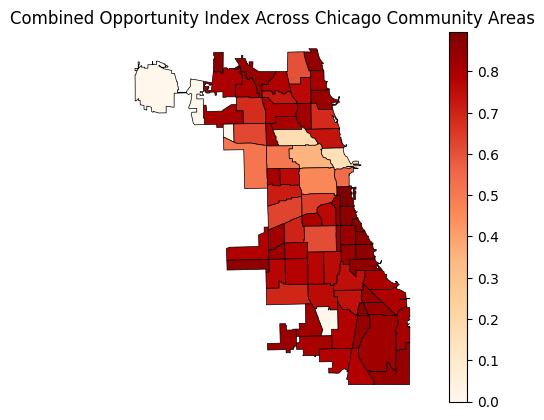

,ca_num,ca_name,business_license_count,food_inspections_count,liquor_license_count,building_permits_count,pct_dependents,pct_working_age,per_capita_income,hardship_index,...,bars_undersupply_raw,bars_undersupply,gym_need,gym_supply,gyms_undersupply_raw,gyms_undersupply,shop_need,shops_undersupply_raw,shops_undersupply,combined_opportunity_index
24,33,NEAR SOUTH SIDE,2.0,14.0,17.0,12.0,21.8,78.2,59077.0,7.0,...,68.968056,0.989558,78.2,0.047619,74.476190,1.000000,100.0,94.285714,0.942857,0.895911
75,36,OAKLAND,0.0,0.0,0.0,1.0,40.4,59.6,19252.0,78.0,...,59.600000,0.855144,59.6,0.000000,59.600000,0.800256,100.0,100.000000,1.000000,0.875719
69,39,KENWOOD,0.0,3.0,1.0,6.0,35.4,64.6,35911.0,26.0,...,64.151389,0.920448,64.6,0.000000,64.600000,0.867391,100.0,100.000000,1.000000,0.873763
76,47,BURNSIDE,0.0,0.0,0.0,1.0,42.7,57.3,12515.0,79.0,...,57.300000,0.822144,57.3,0.000000,57.300000,0.769373,100.0,100.000000,1.000000,0.870106
61,9,EDISON PARK,2.0,4.0,2.0,2.0,35.3,64.7,40959.0,8.0,...,63.801389,0.915426,64.7,0.047619,61.619048,0.827366,100.0,94.285714,0.942857,0.866226
58,35,DOUGLAS,1.0,7.0,2.0,4.0,30.7,69.3,23791.0,47.0,...,68.337500,0.980511,69.3,0.023810,67.650000,0.908344,100.0,97.142857,0.971429,0.863024
25,41,HYDE PARK,4.0,18.0,12.0,4.0,26.2,73.8,39056.0,14.0,...,67.650000,0.970646,73.8,0.095238,66.771429,0.896547,100.0,88.571429,0.885714,0.857698
39,1,ROGERS PARK,2.0,5.0,17.0,9.0,27.5,72.5,23939.0,39.0,...,63.940972,0.917429,72.5,0.047619,69.047619,0.927110,100.0,94.285714,0.942857,0.856980
55,64,CLEARING,1.0,5.0,5.0,6.0,37.6,62.4,25113.0,29.0,...,60.233333,0.864231,62.4,0.023810,60.914286,0.817903,100.0,97.142857,0.971429,0.856726
33,42,WOODLAWN,1.0,19.0,1.0,11.0,36.1,63.9,18672.0,58.0,...,63.456250,0.910474,63.9,0.023810,62.378571,0.837564,100.0,97.142857,0.971429,0.856409


In [43]:
# -----------------------------------------------------------
# 8. Choropleth map of combined opportunity index
# -----------------------------------------------------------

plt.figure(figsize=(12, 10))
gdf.plot(
    column="combined_opportunity_index",
    cmap="OrRd",
    legend=True,
    edgecolor="black",
    linewidth=0.5
)
plt.title("Combined Opportunity Index Across Chicago Community Areas")
plt.axis("off")
plt.show()

# Save output
df.to_csv("../datasets/combined_opportunity_index_by_CA.csv", index=False)

df.sort_values("combined_opportunity_index", ascending=False).head(10)


In [44]:
# print all the info of burnside

print(df[df['ca_name'] == 'BURNSIDE'].to_string())
print(df[df['ca_name'] == 'MONTCLARE'].to_string())
print(df[df['ca_name'] == 'OAKLAND'].to_string())

    ca_num   ca_name  business_license_count  food_inspections_count  liquor_license_count  building_permits_count  pct_dependents  pct_working_age  per_capita_income  hardship_index  scaled_business_license_count  scaled_food_inspections_count  scaled_liquor_license_count  scaled_building_permits_count  saturation_index  retail_count  school_count  scaled_retail_count  scaled_school_count  school_need  schools_undersupply_raw  schools_undersupply  bars_need  bars_undersupply_raw  bars_undersupply  gym_need  gym_supply  gyms_undersupply_raw  gyms_undersupply  shop_need  shops_undersupply_raw  shops_undersupply  combined_opportunity_index
76      47  BURNSIDE                     0.0                     0.0                   0.0                     1.0            42.7             57.3            12515.0            79.0                            0.0                            0.0                          0.0                       0.009009          0.001802           0.0             1    